# Kajabi Data Challenge 
Creator : Riley Cohen

Note that most of the commentary for the results produced in this notebook are in the google slide presentation.

In [1]:
#Basic libraries for computing and visualization
from __future__ import division
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

#Basic libraries for ML and Neural Networks
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy import stats

from sklearn.cluster import KMeans
from xgboost import plot_importance
import xgboost as xgb
from scipy import stats
from sklearn.metrics import precision_recall_fscore_support, classification_report,confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout


First let's read the data.

In [2]:
df = pd.read_csv(r'/Users/rileycohen/Downloads/data_analyst_challange.csv').drop_duplicates()
print(df.shape)
df.head(2)

(38893, 19)


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.



Account ID Cancel Date  Created Date Has Activated (Yes / No)  \
0      108353     7/21/20  6/23/20 0:00                       No   
1      126796      2/5/21  10/8/20 0:00                      Yes   

     Experience        Industry      Initial Trial End Date  \
0           NaN             NaN      Tuesday, July 21, 2020   
1  New Business  Health Fitness  Thursday, November 5, 2020   

  Is Referral (Yes / No)   Original Plan Name Original Plan Interval  \
0                     No  Basic Monthly Trial                Monthly   
1                    Yes  Basic Monthly Trial                Monthly   

               Signup Source Transacted During Trial (Yes / No)  \
0  28 Day Challenge Relaunch                                 No   
1  28 Day Challenge Relaunch                                 No   

  Created Email Broadcast During Trial (Yes / No)  \
0                                              No   
1                                              No   

  Created Email Sequence During Trial (Yes / No) Created Offer Durring Trial  \
0                                             No                          No   
1                                             No                         Yes   

  Uploaded Video Durring Trial  Trial Logins  Utm Medium  \
0                           No            218        NaN   
1                           No            205        NaN   

   Trial Activity Mins (Avg)  
0                  11.800000  
1                  13.196891

Let's see examine the activation and churn rate of the dataset.

In [3]:
df.iloc[:,3].value_counts()

No     20155
Yes    18738
Name: Has Activated (Yes / No), dtype: int64

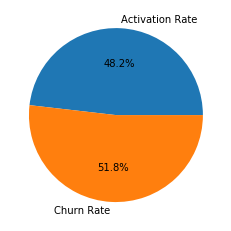

In [4]:
plt.pie([18738,20155], labels=['Activation Rate', 'Churn Rate'], autopct='%1.1f%%');

Now let's get a sense of which features play a strong role in account activation and account churning.

In [5]:
df['Has Activated (Yes / No)'] = df['Has Activated (Yes / No)'].apply(lambda x : 1 if x=='Yes' else 0)

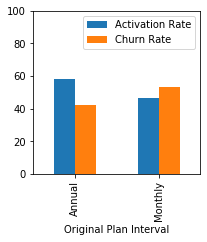

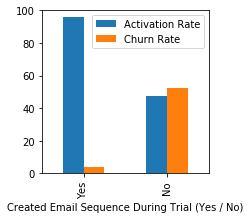

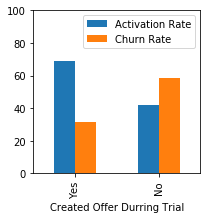

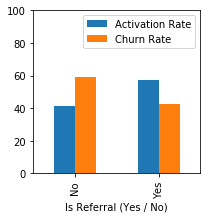

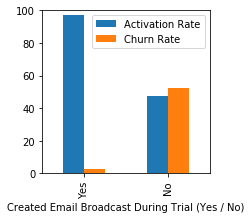

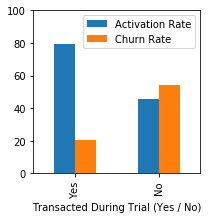

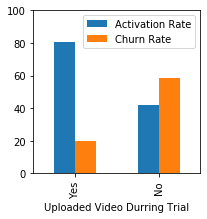

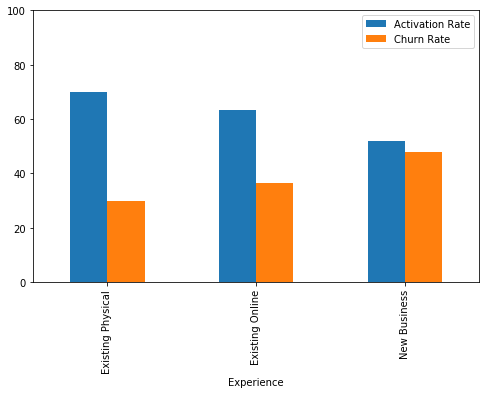

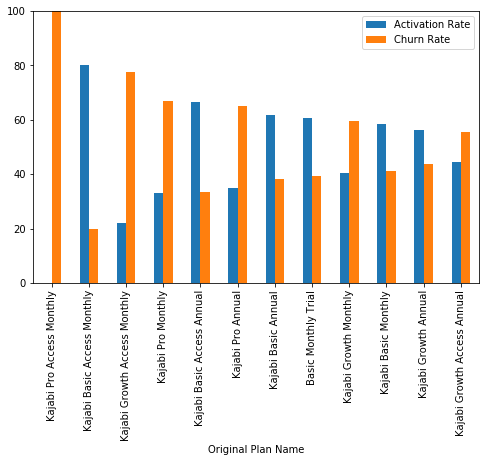

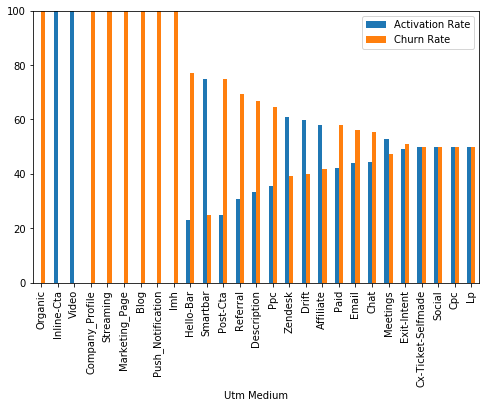

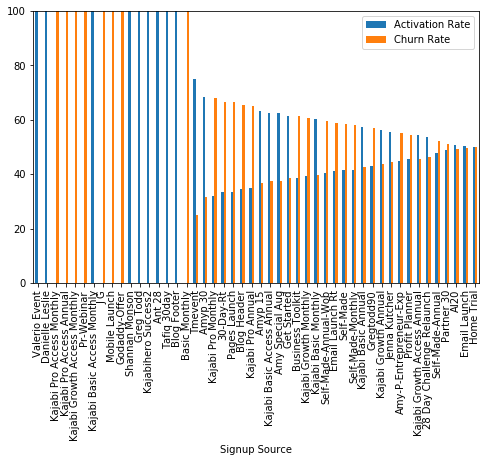

In [6]:
def compare_plot(col, size = (3,3)):
    x = df.groupby(col).mean()[['Has Activated (Yes / No)']]
    x.columns = ['Activation Rate']
    x['Churn Rate'] = 1 - x['Activation Rate']
    x['diff'] = (x['Activation Rate'] - x['Churn Rate']).apply(abs)
    x = x.sort_values('diff', ascending = False).iloc[:,0:2] * 100
    x.plot(kind = 'bar', figsize = size, ylim = (0,100), rot = 90).legend(loc=1, prop={'size': 10})
    return 


cols = ['Experience', 'Original Plan Name', 'Utm Medium' , 'Signup Source']
cols2 = set(['Experience', 'Is Referral (Yes / No)', 'Original Plan Name', 
       'Original Plan Interval', 'Transacted During Trial (Yes / No)',
       'Created Email Broadcast During Trial (Yes / No)',
       'Created Email Sequence During Trial (Yes / No)',
        'Created Offer Durring Trial', 'Uploaded Video Durring Trial']) - set(cols)


[compare_plot(x) for x in cols2];
[compare_plot(x, size=(8,5)) for x in cols];

Next let's view the number of unique values in each column to get an idea on how to best prepare this data for a proper analysis.

In [7]:
col_counts = df.nunique()
col_counts.sort_values()

Original Plan Interval                                 2
Created Offer Durring Trial                            2
Created Email Sequence During Trial (Yes / No)         2
Has Activated (Yes / No)                               2
Created Email Broadcast During Trial (Yes / No)        2
Transacted During Trial (Yes / No)                     2
Is Referral (Yes / No)                                 2
Uploaded Video Durring Trial                           2
Experience                                             3
Original Plan Name                                    12
Utm Medium                                            27
Signup Source                                         48
Created Date                                         233
Initial Trial End Date                               274
Cancel Date                                          353
 Trial Logins                                        671
Industry                                             841
Trial Activity Mins (Avg)      

From above, it is clear that a majority of the data is categorical. whose unique count

Below I define:


- **features_to_encode** which is composed of the columns of the orginal dataframe that have at most 3 unique values.
- **higer_counts** which is composed of the columns from the original dataframe that have a medium number of values
- **industry** which is just a one hot encoding of the industry column. I seperate this feature because it is compused on over 800 values.
- **other_features** which is just the remaining numeric and datetime features

Let's start with features_to_encode.

In [8]:
features_to_encode = col_counts.loc[col_counts <= 3].index #Extract index of rows with desired unique value counts
features_to_encode = df[features_to_encode] #Extract desired sub dataframe 
 
#map specific values
features_to_encode = features_to_encode.replace('Yes',1)
features_to_encode = features_to_encode.replace('No',0)
features_to_encode = features_to_encode.replace('Annual', 0)
features_to_encode = features_to_encode.replace('Monthly', 1)
features_to_encode = pd.get_dummies(features_to_encode) #One hot encode categorical features that have not been mapped

print(features_to_encode.shape)
features_to_encode.head()

(38893, 11)


Has Activated (Yes / No)  Is Referral (Yes / No)  Original Plan Interval  \
0                         0                       0                       1   
1                         1                       1                       1   
2                         0                       1                       1   
3                         1                       1                       1   
4                         1                       1                       1   

   Transacted During Trial (Yes / No)  \
0                                   0   
1                                   0   
2                                   0   
3                                   0   
4                                   0   

   Created Email Broadcast During Trial (Yes / No)  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   Created Email Sequence During Trial (Yes / No)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Created Offer Durring Trial  Uploaded Video Durring Trial  \
0                          0.0                           0.0   
1                          1.0                           0.0   
2                          0.0                           0.0   
3                          0.0                           0.0   
4                          0.0                           0.0   

   Experience_Existing Online  Experience_Existing Physical  \
0                           0                             0   
1                           0                             0   
2                           0                             1   
3                           0                             0   
4                           1                             0   

   Experience_New Business  
0                        0  
1                        1  
2                        0  
3                        1  
4                        0

Below I compute the mean of each column to get a better sense of the distribution of each feature.

In [9]:
df[col_counts.loc[col_counts <= 3].index].isna().sum() #Check Null counts in each column

Has Activated (Yes / No)                               0
Experience                                         13994
Is Referral (Yes / No)                                 0
Original Plan Interval                                 0
Transacted During Trial (Yes / No)                     0
Created Email Broadcast During Trial (Yes / No)        0
Created Email Sequence During Trial (Yes / No)         0
Created Offer Durring Trial                         2378
Uploaded Video Durring Trial                        2378
dtype: int64

Monthly Plan                            0.864577
Activated                               0.481783
Is Referral                             0.439668
Experienced Online Business             0.416844
New Business                            0.327563
Created Offer Durring Trial             0.272299
Experienced Physical Business           0.255593
Uploaded Video Durring Trial            0.192469
Transacted During Trial                 0.071195
Created Email Sequence During Trial     0.011519
Created Email Broadcast During Trial    0.008870
dtype: float64

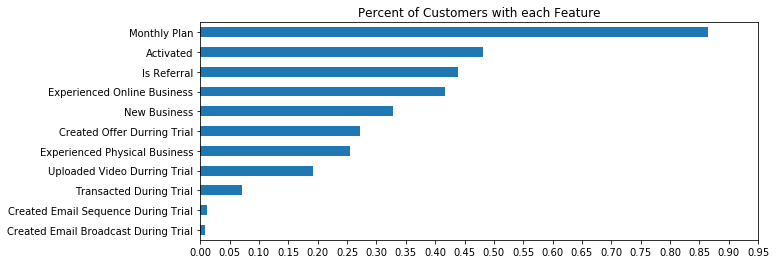

In [10]:
x = len(df) - df[['Experience', 
                'Created Offer Durring Trial', 
                'Uploaded Video Durring Trial']].isna().sum()

lengths = [len(df) for k in range(6)] + [x[1], x[2], x[0], x[0], x[0]]
y = np.array(lengths) #This makes sure that I don't consider the missing values in the mean calculation

z = (features_to_encode/y).sum().sort_values(ascending = True) #Computes the mean for each feature

index = ['Created Email Broadcast During Trial','Created Email Sequence During Trial','Transacted During Trial',
'Uploaded Video Durring Trial' ,'Experienced Physical Business','Created Offer Durring Trial','New Business',
'Experienced Online Business','Is Referral','Activated','Monthly Plan']

index_map = {z.index[k]:index[k] for k in range(len(index))}

z.index = index



plt.figure(figsize = (10,4))
z.plot(kind = 'barh')
plt.xticks(np.arange(0,1,.05));
plt.title('Percent of Customers with each Feature');
z.sort_values(ascending = False)

Let's first first examine how each feature in features_to _encode relates to customers who activate. Below I find the percent of Activated and Churn customers that have the given feature. This means that for the last row corresponding to Original Plan Interval, 89% Churn customers start monthly and 83% active start monthly and so forth.

In [11]:
c = features_to_encode.groupby('Has Activated (Yes / No)').describe().T.reset_index()
c = c[c['level_1']=='mean'].set_index('level_0').iloc[:,1:].sort_values(1, ascending = False)
c.columns = ['Churn', 'Activated']

c = c.sort_values('Activated', ascending = True)
index = [index_map.get(k) for k in c.index]
c.index = index
#swap columns for color coding
a = c.Churn.copy()
b = c.Activated.copy()
c.Churn = b
c.Activated = a
c.columns = ['Activated', 'Churn']
c

Activated     Churn
Created Email Broadcast During Trial   0.017878  0.000496
Created Email Sequence During Trial    0.022948  0.000893
Transacted During Trial                0.117302  0.028330
New Business                           0.226385  0.194195
Experienced Physical Business          0.237912  0.094567
Uploaded Video Durring Trial           0.314654  0.074539
Experienced Online Business            0.351265  0.188390
Created Offer Durring Trial            0.381120  0.167268
Is Referral                            0.521560  0.363533
Monthly Plan                           0.836642  0.890548

Let's visualize this

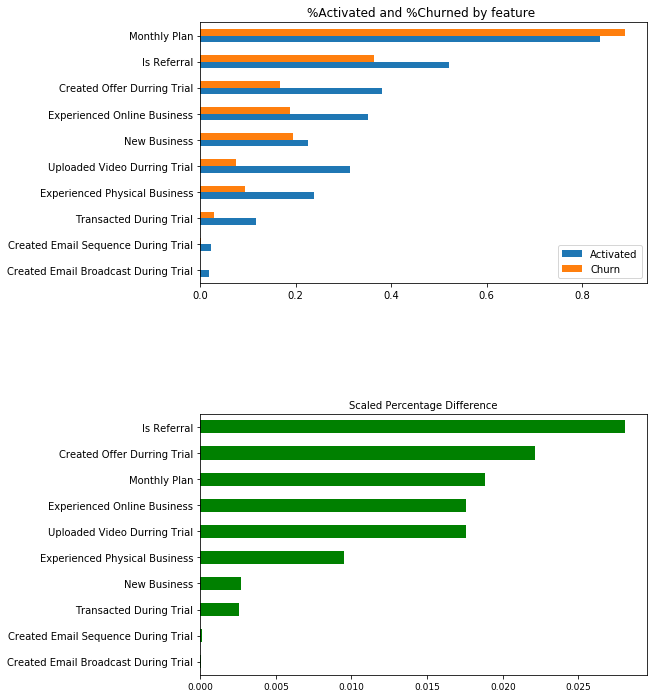

In [12]:
c = features_to_encode.groupby('Has Activated (Yes / No)').describe().T.reset_index()
c = c[c['level_1']=='mean'].set_index('level_0').iloc[:,1:].sort_values(1, ascending = False)
c.columns = ['Churn', 'Activated']

c = c.sort_values('Activated', ascending = True)
index = [index_map.get(k) for k in c.index]
c.index = index
#Swap colors of bars
a = c.Churn.copy()
b = c.Activated.copy()
c.Churn = b
c.Activated = a
c.columns = ['Activated', 'Churn']
c

fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (8,12))

c['sum'] = (c.Activated + c.Churn)
c = c.sort_values('sum', ascending = True)
c.iloc[:,0:2].plot(kind = 'barh', ax=axes[0], title = '%Activated and %Churned by feature ', fontsize = 10)
axes[0].title.set_size(12)
fig.subplots_adjust(hspace=.5)
plt.yticks(fontsize = 5);
plt.xticks(fontsize = 7);


c['difference'] = (c.Activated - c.Churn).apply(abs)
c = c.sort_values('difference', ascending = True)
idx = [index_map.get(k) for k in features_to_encode.sum()[1:].index]
dt = features_to_encode.sum()[1:]
dt.index = idx
h = (c.reindex(index=dt.index).difference * dt)/dt.sum()
h = h.sort_values()
h.plot(kind = 'barh', color = 'green', ax=axes[1])
axes[1].title.set_size(15)
plt.title('Scaled Percentage Difference', fontsize = 10);
plt.yticks(fontsize = 10);
plt.xticks(fontsize = 9);

Now let's view the non-binary features

In [13]:
original_plan_name = pd.get_dummies(df[col_counts.loc[col_counts == 12].index])
utm = pd.get_dummies(df[col_counts.loc[col_counts == 27].index])
signup_source = pd.get_dummies(df[col_counts.loc[col_counts == 48].index])
original_plan_name['activated'] = features_to_encode['Has Activated (Yes / No)']
utm['activated'] = features_to_encode['Has Activated (Yes / No)']
signup_source['activated'] = features_to_encode['Has Activated (Yes / No)']
higher_counts = pd.concat([original_plan_name, utm, signup_source], axis = 1)
print(higher_counts.shape)
higher_counts.head()

(38893, 90)


Original Plan Name_Basic Monthly Trial  \
0                                       1   
1                                       1   
2                                       1   
3                                       1   
4                                       1   

   Original Plan Name_Kajabi Basic Access Annual  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   Original Plan Name_Kajabi Basic Access Monthly  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Original Plan Name_Kajabi Basic Annual  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   

   Original Plan Name_Kajabi Basic Monthly  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   Original Plan Name_Kajabi Growth Access Annual  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Original Plan Name_Kajabi Growth Access Monthly  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   Original Plan Name_Kajabi Growth Annual  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   Original Plan Name_Kajabi Growth Monthly  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   Original Plan Name_Kajabi Pro Access Monthly  ...  \
0                                             0  ...   
1                                             0  ...   
2                                             0  ...   
3                                             0  ...   
4                                             0  ...   

   Signup Source_Profit Planner  Signup Source_Self-Made  \
0                             0                        0   
1                             0                        0   
2                             0                        0   
3                             0                        0   
4                             0                        0   

   Signup Source_Self-Made-Annual  Signup Source_Self-Made-Annual-Wob  \
0                               0                                   0   
1                               0                                   0   
2                               0                                   0   
3                               0                                   0   
4                               0                                   0   

   Signup Source_Self-Made-Monthly  Signup Source_Shannan Monson  \
0                                0                             0   
1                                0                             0   
2      

In [14]:
price = {'Basic Monthly Trial':'Basic Monthly', 'Kajabi Basic Access Annual': 'Basic Annual',
       'Kajabi Basic Access Monthly':'Basic Monthly', 'Kajabi Basic Annual':'Basic Annual',
       'Kajabi Basic Monthly':'Basic Monthly', 'Kajabi Growth Access Annual':'Growth Annual',
       'Kajabi Growth Access Monthly':'Growth Monthly', 'Kajabi Growth Annual':'Growth Annual',
       'Kajabi Growth Monthly':'Growth Monthly', 'Kajabi Pro Access Monthly':'Pro Monthly',
       'Kajabi Pro Annual':'Pro Annual', 'Kajabi Pro Monthly':'Pro Monthly'}

In [15]:
c1 = original_plan_name.groupby('activated').describe().T.reset_index()
c1 = c1[c1['level_1']=='mean'].set_index('level_0').iloc[:,1:].sort_values(1, ascending = False)
c1.columns = ['Churn', 'Activated']

c2 = utm.groupby('activated').describe().T.reset_index()
c2 = c2[c2['level_1']=='mean'].set_index('level_0').iloc[:,1:].sort_values(1, ascending = False)
c2.columns = ['Churn', 'Activated']

c3 = signup_source.groupby('activated').describe().T.reset_index()
c3 = c3[c3['level_1']=='mean'].set_index('level_0').iloc[:,1:].sort_values(1, ascending = False)
c3.columns = ['Churn', 'Activated']


display(c1,c2,c3)

Churn  Activated
level_0                                                             
Original Plan Name_Kajabi Growth Monthly         0.647929   0.471075
Original Plan Name_Kajabi Basic Monthly          0.237063   0.361725
Original Plan Name_Kajabi Basic Annual           0.046787   0.081119
Original Plan Name_Kajabi Growth Annual          0.057256   0.078877
Original Plan Name_Kajabi Pro Annual             0.005061   0.002935
Original Plan Name_Kajabi Pro Monthly            0.004317   0.002295
Original Plan Name_Basic Monthly Trial           0.000744   0.001227
Original Plan Name_Kajabi Basic Access Annual    0.000099   0.000213
Original Plan Name_Kajabi Basic Access Monthly   0.000050   0.000213
Original Plan Name_Kajabi Growth Access Annual   0.000248   0.000213
Original Plan Name_Kajabi Growth Access Monthly  0.000347   0.000107
Original Plan Name_Kajabi Pro Access Monthly     0.000099   0.000000

Churn  Activated
level_0                                           
Utm Medium_Affiliate           0.311784   0.464404
Utm Medium_Paid                0.212999   0.166400
Utm Medium_Email               0.040337   0.033835
Utm Medium_Drift               0.003523   0.005657
Utm Medium_Chat                0.005706   0.004910
Utm Medium_Exit-Intent         0.001439   0.001494
Utm Medium_Zendesk             0.000893   0.001494
Utm Medium_Ppc                 0.000992   0.000587
Utm Medium_Meetings            0.000447   0.000534
Utm Medium_Referral            0.000893   0.000427
Utm Medium_Cpc                 0.000198   0.000213
Utm Medium_Social              0.000198   0.000213
Utm Medium_Hello-Bar           0.000496   0.000160
Utm Medium_Smartbar            0.000050   0.000160
Utm Medium_Post-Cta            0.000298   0.000107
Utm Medium_Description         0.000099   0.000053
Utm Medium_Video               0.000000   0.000053
Utm Medium_Lp                  0.000050   0.000053
Utm Medium_Cx-Ticket-Selfmade  0.000050   0.000053
Utm Medium_Inline-Cta          0.000000   0.000053
Utm Medium_Organic             0.000050   0.000000
Utm Medium_Push_Notification   0.000050   0.000000
Utm Medium_Marketing_Page      0.000050   0.000000
Utm Medium_Blog                0.000050   0.000000
Utm Medium_Streaming           0.000050   0.000000
Utm Medium_Imh                 0.000050   0.000000
Utm Medium_Company_Profile     0.000099   0.000000

Churn  Activated
level_0                                                        
Signup Source_Kajabi Growth Monthly         0.525478   0.368609
Signup Source_28 Day Challenge Relaunch     0.147953   0.185185
Signup Source_Get Started                   0.073977   0.126107
Signup Source_Kajabi Basic Annual           0.067824   0.098143
Signup Source_Kajabi Growth Annual          0.047929   0.066389
Signup Source_Kajabi Basic Monthly          0.029968   0.049151
Signup Source_Amyp 30                       0.010469   0.024389
Signup Source_Email Launch Rt               0.022228   0.016811
Signup Source_Business Toolkit              0.021186   0.014409
Signup Source_Al20                          0.006996   0.007738
Signup Source_Self-Made-Annual              0.007442   0.007311
Signup Source_Email Launch                  0.005061   0.005550
Signup Source_Jenna Kutcher                 0.003672   0.004910
Signup Source_Kajabi Pro Annual             0.006748   0.003896
Signup Source_Self-Made-Annual-Wob          0.004962   0.003629
Signup Source_Amyp 15                       0.001786   0.003309
Signup Source_Partner 30                    0.003175   0.003255
Signup Source_Self-Made-Monthly             0.004019   0.003095
Signup Source_Amy Special Aug               0.000744   0.001334
Signup Source_Kajabi Pro Monthly            0.002530   0.001281
Signup Source_Amy-P-Entrepreneur-Exp        0.001340   0.001174
Signup Source_Self-Made                     0.001191   0.000907
Signup Source_Blog Header                   0.000943   0.000534
Signup Source_Danielle Leslie               0.000000   0.000427
Signup Source_Kajabi Growth Access Annual   0.000248   0.000320
Signup Source_Kajabi Basic Access Annual    0.000149   0.000267
Signup Source_Profit Planner                0.000298   0.000267
Signup Source_30-Day-Rt                     0.000298   0.000160
Signup Source_Tmevent                       0.000050   0.000160
Signup Source_Ant 28                        0.000000   0.000160
Signup Source_Gregtodd90                    0.000198   0.000160
Signup Source_Kajabihero Success2           0.000000   0.000107
Signup Source_Kajabi Basic Access Monthly   0.000000   0.000107
Signup Source_Greg Todd                     0.000000   0.000053
Signup Source_Tafiq 30day                   0.000000   0.000053
Signup Source_Shannan Monson                0.000000   0.000053
Signup Source_Blog Footer                   0.000000   0.000053
Signup Source_Pages Launch                  0.000099   0.000053
Signup Source_Home Trial                    0.000050   0.000053
Signup Source_Valerio Event                 0.000000   0.000053
Signup Source_Pr-Webinar                    0.000050   0.000000
Signup Source_Mobile Launch                 0.000248   0.000000
Signup Source_Godaddy-Offer                 0.000050   0.000000
Signup Source_Basic Monthly                 0.000050   0.000000
Signup Source_Kajabi Pro Access Monthly     0.000050   0.000000
Signup Source_Kajabi Pro Access Annual      0.000050   0.000000
Signup Source_J G                           0.000099   0.000000
Signup Source_Kajabi Growth Access Monthly  0.000347   0.000000

Now let's encode the Industry field entirely by itself because it has a very large number of possible values.

In [16]:
industry = pd.get_dummies(df[['Industry']])
print(industry.shape)
industry.head(1)

(38893, 841)


Industry_Academics Teacher Training  \
0                                    0   

   Industry_Academics Teacher Training Business Finance  \
0                                                  0      

   Industry_Academics Teacher Training Business Finance Design  \
0                                                  0             

   Industry_Academics Teacher Training Business Finance Design Family Parenting  \
0                                                  0                              

   Industry_Academics Teacher Training Business Finance Design Family Parenting Fashion Beauty  \
0                                                  0                                             

   Industry_Academics Teacher Training Business Finance Design Family Parenting Fashion Beauty Health Fitness  \
0                                                  0                                                            

   Industry_Academics Teacher Training Business Finance Design Family Parenting Fashion Beauty Health Fitness Lifestyle Hobbies Marketing Music Instruments Organization Productivity Personal Development Photo Video Software Technology Travel Languages  \
0                                                  0                                                                                                                                                                                                          

   Industry_Academics Teacher Training Business Finance Design Family Parenting Fashion Beauty Health Fitness Lifestyle Hobbies Marketing Music Instruments Organization Productivity Personal Development Photo Video Software Technology Travel Languages Other  \
0                                                  0                                                                                                                                                                                                                

   Industry_Academics Teacher Training Business Finance Design Family Parenting Fashion Beauty Health Fitness Lifestyle Hobbies Marketing Music Instruments Organization Productivity Personal Development Photo Video Travel Languages Other  \
0                                                  0                                                                                                                                                                                            

   Industry_Academics Teacher Training Business Finance Design Family Parenting Fashion Beauty Health Fitness Music Instruments Organization Productivity Personal Development Photo Video Software Technology Travel Languages Other  \
0                                                  0                                                                                                                                                                                    

   ...  Industry_Photo Video Other  Industry_Photo Video Software Technology  \
0  ...                           0                                         0   

   Industry_Photo Video Software Technology Other  \
0                                               0   

   Industry_Photo Video Software Technology Travel Languages  \
0                                                  0           

   Industry_Photo Video Travel Languages  Industry_Software Technology  \
0                                      0                             0   

   Industry_Software Technology Other  \
0                                   0   

   Industry_Software Technology Travel Languages  Industry_Travel Languages  \
0                                              0                          0   

   Industry_Travel Languages Other  
0                                0  

[1 rows x 841 columns]

Lastly let's extract the numeric and date features as well as create new features.

In [17]:
other_features = col_counts.loc[col_counts > 50].index
other_features = df[other_features].reset_index(drop = True).drop(columns = 'Industry')

other_features.loc[:,'Cancel Date'] = pd.to_datetime(df.loc[:,'Cancel Date'].astype(str))
other_features['Created Date'] = pd.to_datetime(other_features['Created Date'].astype(str))
other_features['Initial Trial End Date'] = pd.to_datetime(other_features['Initial Trial End Date'].astype(str))
other_features[' Trial Logins '] = other_features[' Trial Logins '].astype(str).apply(lambda x: x.replace(',', '')).astype(float)


other_features['Login*Time'] = (other_features[' Trial Logins '] * other_features['Trial Activity Mins (Avg)']).fillna(0)
other_features['Trial Length'] = (other_features['Initial Trial End Date'] - other_features['Created Date']).dt.days.fillna(0)
other_features['Time/Login'] = (1/(other_features[' Trial Logins '].astype(float) / other_features['Trial Activity Mins (Avg)'].astype(float))).fillna(0).replace(np.inf,0)
other_features['Login*Time'] = (other_features[' Trial Logins '] * other_features['Trial Activity Mins (Avg)']).fillna(0)
other_features['Login*Length'] = (other_features[' Trial Logins '] * other_features['Trial Length']).fillna(0)


other_features.head()

Account ID Cancel Date Created Date Initial Trial End Date   Trial Logins   \
0      108353  2020-07-21   2020-06-23             2020-07-21           218.0   
1      126796  2021-02-05   2020-10-08             2020-11-05           205.0   
2      131192  2020-11-28   2020-10-31             2020-11-28           193.0   
3      113953         NaT   2020-07-29             2020-08-26           186.0   
4       99550         NaT   2020-05-06             2020-06-03           174.0   

   Trial Activity Mins (Avg)   Login*Time  Trial Length  Time/Login  \
0                  11.800000  2572.400000            28    0.054128   
1                  13.196891  2705.362655            28    0.064375   
2                  10.800000  2084.400000            28    0.055959   
3                  15.060606  2801.272716            28    0.080971   
4                  10.681818  1858.636332            28    0.061390   

   Login*Length  
0        6104.0  
1        5740.0  
2        5404.0  
3        5208.0  
4        4872.0

In [18]:
month = ['May', 'June', 'July', 'August', 'September', 'October', 'November', ' December']

price = {'Basic Monthly Trial':0, 'Kajabi Basic Access Annual':119,
       'Kajabi Basic Access Monthly':149, 'Kajabi Basic Annual':119,
       'Kajabi Basic Monthly':149, 'Kajabi Growth Access Annual':199,
       'Kajabi Growth Access Monthly':159, 'Kajabi Growth Annual':199,
       'Kajabi Growth Monthly':199, 'Kajabi Pro Access Monthly':399,
       'Kajabi Pro Annual':319, 'Kajabi Pro Monthly':399}

Since december is not finished, I am going to find what percent of the revenue, new customers and activation rate come from the last 10-12 each month and add this onto December. To do this I create very simple linear regression models.

In [19]:
other_features
dates = pd.to_datetime(other_features['Created Date'])
m = dates.dt.month
time = pd.DataFrame({'month':m, 'day':dates.dt.day})
year_month = pd.to_datetime(other_features['Created Date']).map(lambda date: 100*date.year + date.month)
time['year_month'] = year_month
time['19+'] = (time.day > 19) * 1
time['activated'] = features_to_encode['Has Activated (Yes / No)']
time['revenue'] = df['Original Plan Name'].apply(lambda x: price.get(x))
f = time[time['19+'] == 1].groupby('month').sum().reset_index()[['month','revenue']] #Days past 19th day of month
b = time[time['19+'] != 1].groupby('month').sum().reset_index()[['month','revenue']] # First 19 days
f['first_rev'] = b.revenue[0:-1]
f.columns = ['month', 'last19_rev','first19_rev']
f

month  last19_rev  first19_rev
0      5    353628.0     629847.0
1      6    326037.0     580717.0
2      7    331438.0     489914.0
3      8    343421.0     560600.0
4      9    345353.0     602341.0
5     10    352900.0     578058.0
6     11    355430.0     585618.0

In [20]:
sub = other_features.iloc[:,4:]
sub['month'] = time.month
sub = pd.merge(sub, f, on = 'month')
sub = sub[sub.month!=12]
sub.head()

Trial Logins   Trial Activity Mins (Avg)   Login*Time  Trial Length  \
0           218.0                  11.800000  2572.400000            28   
1           150.0                  10.831325  1624.698750            15   
2           144.0                   6.000000   864.000000            28   
3           137.0                   9.107143  1247.678591            28   
4           110.0                  11.685567  1285.412370            28   

   Time/Login  Login*Length  month  last19_rev  first19_rev  
0    0.054128        6104.0      6    326037.0     580717.0  
1    0.072209        2250.0      6    326037.0     580717.0  
2    0.041667        4032.0      6    326037.0     580717.0  
3    0.066475        3836.0      6    326037.0     580717.0  
4    0.106232        3080.0      6    326037.0     580717.0

In [21]:
from sklearn.linear_model import LinearRegression

X  = sub.drop(columns = ['last19_rev']).fillna(0)
y = sub['last19_rev']

reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.5790592581049903

The mean squared error looks good. Now I will predict the revenue for the remaining time in December.

In [22]:
sub = other_features.iloc[:,4:]
sub['month'] = time.month
sub = sub[sub.month == 12].fillna(0)
sub['rev'] = b.revenue[7]
dec_rev = reg.predict(sub).mean()
dec_rev #December last 10-12 days of revenue

348736.1911867056

Next predict the activation rate

In [23]:
sub = other_features.iloc[:,4:]
sub['month'] = time.month
#sub = pd.merge(sub, f, on = 'month')
sub['activated'] = features_to_encode['Has Activated (Yes / No)']
sub.head()
act_rate = sub.groupby('month').mean().activated.reset_index()
act_rate
sub = pd.merge(sub, act_rate, on = 'month')
sub = sub[sub.month!=12]


X  = sub.drop(columns = ['activated_x','activated_y']).fillna(0)
y = sub['activated_y']

reg = LinearRegression().fit(X, y)


sub = other_features.iloc[:,4:]
sub['month'] = time.month
sub = sub[sub.month == 12].fillna(0)
dec_rate = reg.predict(sub).mean()
dec_rate #December Activation Rate

0.46588690850003867

Next predict the number of new activations 

In [24]:
act_rate

month  activated
0      5   0.490217
1      6   0.487637
2      7   0.495397
3      8   0.494316
4      9   0.479118
5     10   0.473415
6     11   0.463649
7     12   0.467692

In [25]:
sub = other_features.iloc[:,4:]
sub['month'] = time.month
sub['new_acts'] = features_to_encode['Has Activated (Yes / No)']
sub.head()
act_rate = sub.groupby('month').sum().new_acts.reset_index()
act_rate
sub = pd.merge(sub, act_rate, on = 'month')
sub = sub[sub.month!=12]


X  = sub.drop(columns = ['new_acts_x','new_acts_y']).fillna(0)
y = sub['new_acts_y']

reg = LinearRegression().fit(X, y)


sub = other_features.iloc[:,4:]
sub['month'] = time.month
sub = sub[sub.month == 12].fillna(0)
dec_new_acts = reg.predict(sub).mean() - act_rate.new_acts[7]
dec_new_acts #December Number of new activations in last 10-12 days

928.7439535622766

Last predict the number of new customers

In [26]:
year_month = pd.to_datetime(other_features['Created Date']).map(lambda date: 100*date.year + date.month)
time = pd.DataFrame({'year_month': year_month})
#time['activated'] = features_to_encode['Has Activated (Yes / No)'] 
grouped = time.groupby('year_month').size()
grouped.index = np.arange(5,13,1)
grouped = grouped.reset_index()
grouped.columns = ['month', 'new']

sub = other_features.iloc[:,4:]
sub['month'] = dates.dt.month

sub = pd.merge(sub, grouped, on = 'month')
sub = sub[sub.month!=12]

X  = sub.drop(columns = ['new']).fillna(0)
y = sub['new']

reg = LinearRegression().fit(X, y)


sub = other_features.iloc[:,4:]
sub['month'] = dates.dt.month
sub = sub[sub.month == 12].fillna(0)
dec_new_cust = reg.predict(sub).mean() - grouped.new[7] #Total prediction - current number
dec_new_cust #December number of new customers in last 10-12 days

2020.6868793179156

In [27]:
year_month = pd.to_datetime(other_features['Created Date']).map(lambda date: 100*date.year + date.month)
time = pd.DataFrame({'year_month': year_month})
time['activated'] = features_to_encode['Has Activated (Yes / No)'] 
time.head()
grouped = time.groupby('year_month').size()
grouped.loc[202012] = grouped.loc[202012] + dec_new_cust

plot = [
    go.Scatter(
        x = month,
        y = grouped,
        name = 'Activation Rate each Month'
    )
]

layout = go.Layout(
        xaxis={"type": "category"},
        title='New Customers Each Month',
    width=600, height=400
    )
fig = go.Figure(data = plot, layout = layout)

pyoff.iplot(fig)

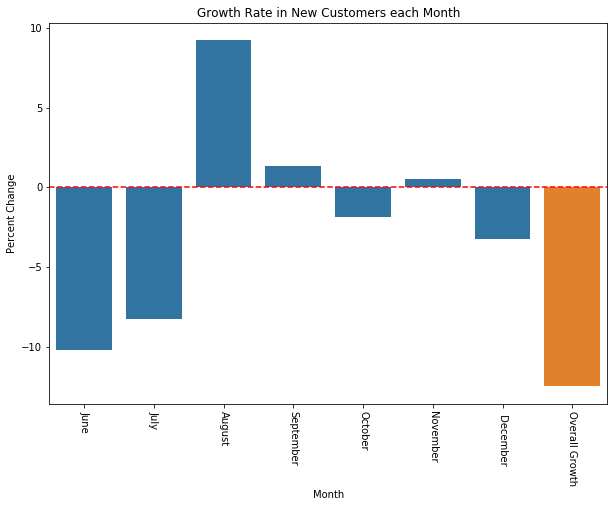

In [28]:
growth = time.groupby('year_month').size()
growth.loc[202012] = growth.loc[202012] + dec_new_cust
growth = growth.pct_change()
increases = growth[growth > 0].sum()
decreases = growth[growth < 0].sum()
growth = growth.append(pd.Series(increases + decreases), ignore_index = True).to_frame()
growth.columns = ['Percent Change']
growth['Month'] = (month + ['Overall Growth'])
growth['Percent Change'] = growth* 100
growth['hue'] = [0 for k in range(8)] + [1]

plt.figure(figsize=(10,7))
sns.barplot(data = growth.iloc[1:,:], x = 'Month', y ='Percent Change', hue = 'hue', dodge=False);
plt.xticks(rotation=270)
plt.axhline(y=0, color='r', linestyle='--')
plt.legend([],[], frameon=False)
plt.title('Growth Rate in New Customers each Month');

In [29]:
year_month = pd.to_datetime(other_features['Created Date']).map(lambda date: 100*date.year + date.month)
time = pd.DataFrame({'year_month': year_month})
time['activated'] = features_to_encode['Has Activated (Yes / No)']
time.head()
grouped = time.groupby('year_month').mean()
grouped.loc[202012] = (grouped.loc[202012] + dec_rate)/2


plot = [
    go.Scatter(
        x = month,
        y = grouped.activated * 100,
        name = 'Activation Rate each Month'
    )
]

layout = go.Layout(
        xaxis={"type": "category"},
        title='Activation Rate each Month',
    width=600, height=400
    )
fig = go.Figure(data = plot, layout = layout)

pyoff.iplot(fig)

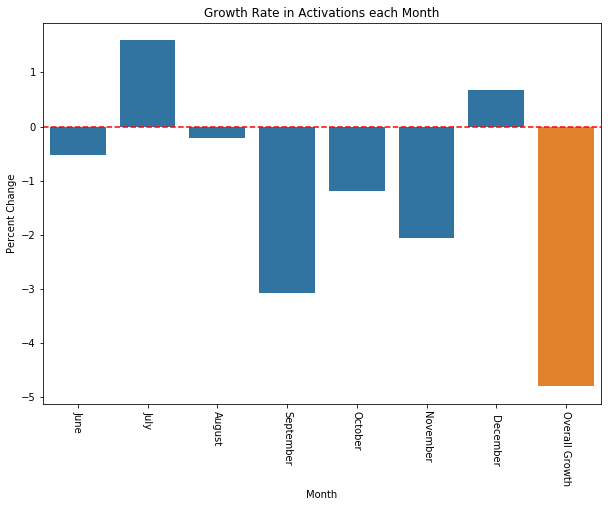

In [30]:
growth = time.groupby('year_month').mean()
growth.loc[202012] = (growth.loc[202012] + dec_rate)/2
growth = growth.pct_change()
increases = growth[growth.activated > 0].sum()
decreases = growth[growth.activated < 0].sum()
growth = growth.append(increases + decreases, ignore_index = True)
growth['Month'] = (month + ['Overall Growth'])
growth['Percent Change'] = growth.activated* 100
growth['hue'] = [0 for k in range(8)] + [1]

plt.figure(figsize=(10,7))
sns.barplot(data = growth.iloc[1:,:], x = 'Month', y ='Percent Change', hue = 'hue', dodge=False);
plt.xticks(rotation=270)
plt.axhline(y=0, color='r', linestyle='--')
plt.legend([],[], frameon=False)
plt.title('Growth Rate in Activations each Month');

In [31]:
year_month = pd.to_datetime(other_features['Created Date']).map(lambda date: 100*date.year + date.month)
time = pd.DataFrame({'year_month': year_month})
time['activated'] = features_to_encode['Has Activated (Yes / No)']
time.head()
grouped = time.groupby('year_month').sum()
grouped.loc[202012] = grouped.loc[202012] + dec_new_acts


plot = [
    go.Scatter(
        x = month,
        y = grouped.activated,
        name = 'Activation Rate'
    )
]

layout = go.Layout(
        xaxis={"type": "category"},
        title='Number of New Activations each Month',
    width=600, height=400
    )
fig = go.Figure(data = plot, layout = layout)

pyoff.iplot(fig)

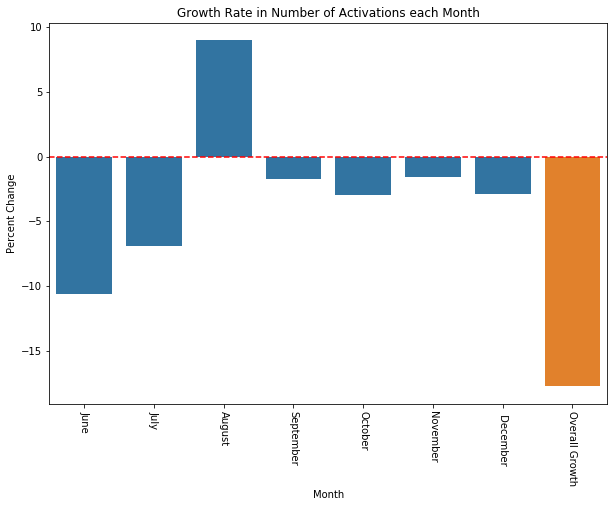

In [32]:
growth = time.groupby('year_month').sum()
growth.loc[202012] = growth.loc[202012] + dec_new_acts
growth = growth.pct_change()
increases = growth[growth.activated > 0].sum()
decreases = growth[growth.activated < 0].sum()
growth = growth.append(increases + decreases, ignore_index = True)
growth['Month'] = (month + ['Overall Growth'])
growth['Percent Change'] = growth.activated* 100
growth['hue'] = [0 for k in range(8)] + [1]

plt.figure(figsize=(10,7))
sns.barplot(data = growth.iloc[1:,:], x = 'Month', y ='Percent Change', hue = 'hue', dodge=False);
plt.xticks(rotation=270)
plt.axhline(y=0, color='r', linestyle='--')
plt.legend([],[], frameon=False)
plt.title('Growth Rate in Number of Activations each Month');

In [33]:
df['Original Plan Name'].unique()

array(['Basic Monthly Trial', 'Kajabi Basic Access Annual',
       'Kajabi Basic Access Monthly', 'Kajabi Basic Annual',
       'Kajabi Basic Monthly', 'Kajabi Growth Access Annual',
       'Kajabi Growth Access Monthly', 'Kajabi Growth Annual',
       'Kajabi Growth Monthly', 'Kajabi Pro Access Monthly',
       'Kajabi Pro Annual', 'Kajabi Pro Monthly'], dtype=object)

In [34]:
price = {'Basic Monthly Trial':0, 'Kajabi Basic Access Annual':119,
       'Kajabi Basic Access Monthly':149, 'Kajabi Basic Annual':119,
       'Kajabi Basic Monthly':149, 'Kajabi Growth Access Annual':199,
       'Kajabi Growth Access Monthly':159, 'Kajabi Growth Annual':199,
       'Kajabi Growth Monthly':199, 'Kajabi Pro Access Monthly':399,
       'Kajabi Pro Annual':319, 'Kajabi Pro Monthly':399}


In [35]:
time['revenue'] = df['Original Plan Name'].apply(lambda x: price.get(x))
grouped = time.groupby('year_month').sum()
grouped.loc[202012] = grouped.loc[202012] + dec_rev
grouped


plot = [
    go.Scatter(
        x = month,
        y = grouped.revenue,
        name = 'Activation Rate'
    )
]

layout = go.Layout(
        xaxis={"type": "category"},
        title='Revenue each Month (According to Original Plan)',
    width=600, height=400
    )
fig = go.Figure(data = plot, layout = layout)

pyoff.iplot(fig)

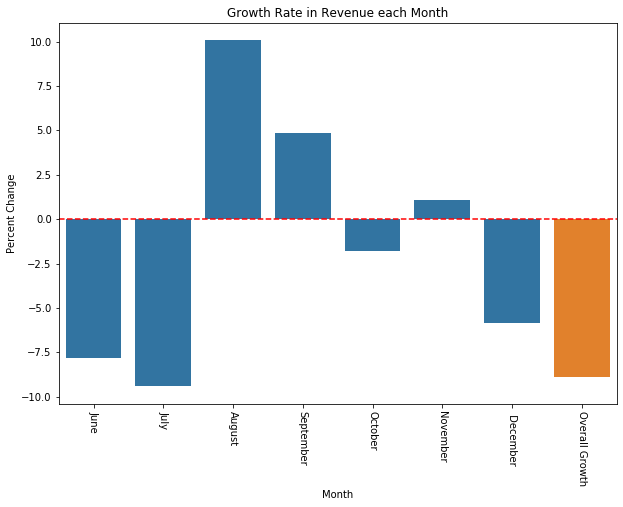

In [36]:
growth = time.groupby('year_month').sum()
growth.loc[202012] = growth.loc[202012] + dec_rev
growth = growth.pct_change()
increases = growth.revenue[growth.revenue > 0].sum()
decreases = growth.revenue[growth.revenue < 0].sum()
growth = growth.reset_index(drop = True).revenue.append(pd.Series([increases + decreases], index = [8]), ignore_index = True).to_frame()
growth['Month'] = (month + ['Overall Growth'])
growth.columns = ['revenue', 'Month']
growth['Percent Change'] = growth.revenue* 100
growth['hue'] = [0 for k in range(8)] + [1]


plt.figure(figsize=(10,7))
sns.barplot(data = growth.iloc[1:,:], x = 'Month', y ='Percent Change', hue = 'hue', dodge=False);
plt.xticks(rotation=270)
plt.axhline(y=0, color='r', linestyle='--')
plt.legend([],[], frameon=False)
plt.title('Growth Rate in Revenue each Month');

In [37]:
other_features.iloc[:, 4:]

Trial Logins   Trial Activity Mins (Avg)   Login*Time  Trial Length  \
0               218.0                  11.800000  2572.400000            28   
1               205.0                  13.196891  2705.362655            28   
2               193.0                  10.800000  2084.400000            28   
3               186.0                  15.060606  2801.272716            28   
4               174.0                  10.681818  1858.636332            28   
...               ...                        ...          ...           ...   
38888            30.0                   2.000000    60.000000            14   
38889            28.0                   3.187500    89.250000            13   
38890            22.0                   2.250000    49.500000            14   
38891            14.0                   2.666667    37.333338            14   
38892             0.0                        NaN     0.000000            14   

       Time/Login  Login*Length  
0        0.054128        6104.0  
1        0.064375        5740.0  
2        0.055959        5404.0  
3        0.080971        5208.0  
4        0.061390        4872.0  
...           ...           ...  
38888    0.066667         420.0  
38889    0.113839         364.0  
38890    0.102273         308.0  
38891    0.190476         196.0  
38892    0.000000           0.0  

[38893 rows x 6 columns]

Let's examine if there is any predictive power in this numeric data.

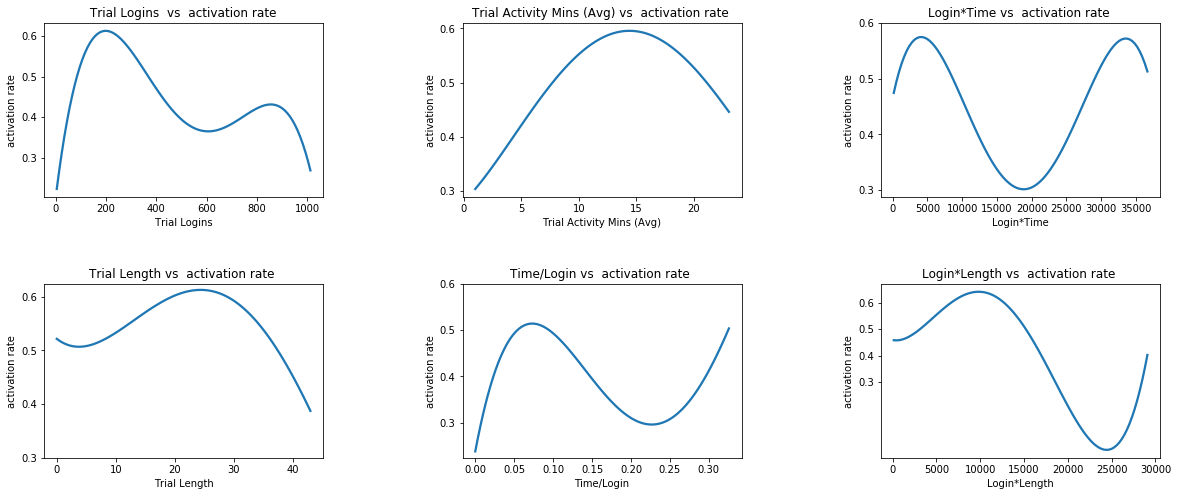

In [38]:
f, axes = plt.subplots(2,3, figsize = (20,8))
cols = other_features.columns

for k in range(6):
    d = pd.DataFrame({ cols[4+k] : other_features.iloc[:, 4+k]})
    d = d[d.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
    bins = pd.cut(d.iloc[:,0], 100, labels=False)
    d['bins'] = bins
    d['activation rate'] = features_to_encode['Has Activated (Yes / No)']
    p = d.groupby('bins').mean()
    p = p[p.apply(lambda x: np.abs(x - x.mean()) / x.std() < 5).all(axis=1)]
    plt.subplot(2,3,k+1)
    sns.regplot(data = p, 
                x = cols[4+k], 
                y = 'activation rate',
                scatter_kws={"s": 80},
                order = 4, 
                ci=None,
               scatter = False)
    plt.title(cols[4+k] + ' vs ' + ' activation rate ')
    plt.yticks(np.arange(.3,.7,.1))
    
f.subplots_adjust(wspace=.5);
f.subplots_adjust(hspace=.5);
#Quality of each login

Check where cancel dates occur 

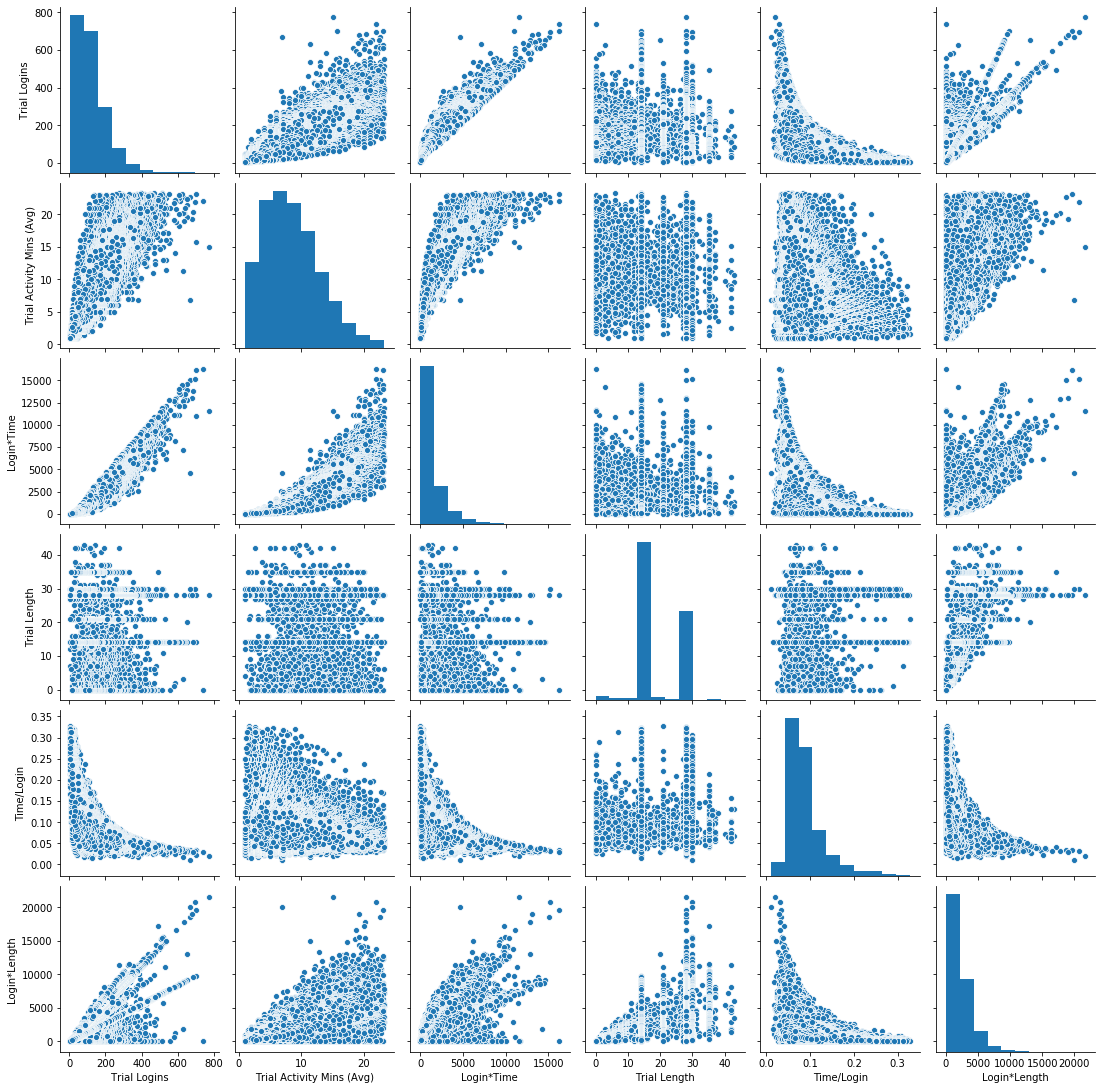

In [39]:
X = other_features.iloc[:, 4:]
X = X[X.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
sns.pairplot(X);

Looks like there is a substantial amount, but let's take a look at a heatmap real quick.

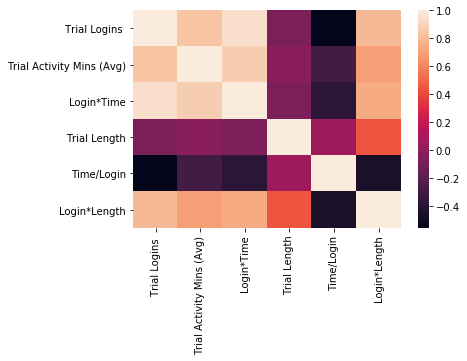

In [40]:
sns.heatmap(X.corr())

Now let's combine all the features together.

In [41]:
df2 = pd.concat([other_features.reset_index(),
                 features_to_encode.reset_index()],
                axis = 1)
df2.head()

index  Account ID Cancel Date Created Date Initial Trial End Date  \
0      0      108353  2020-07-21   2020-06-23             2020-07-21   
1      1      126796  2021-02-05   2020-10-08             2020-11-05   
2      2      131192  2020-11-28   2020-10-31             2020-11-28   
3      3      113953         NaT   2020-07-29             2020-08-26   
4      4       99550         NaT   2020-05-06             2020-06-03   

    Trial Logins   Trial Activity Mins (Avg)   Login*Time  Trial Length  \
0           218.0                  11.800000  2572.400000            28   
1           205.0                  13.196891  2705.362655            28   
2           193.0                  10.800000  2084.400000            28   
3           186.0                  15.060606  2801.272716            28   
4           174.0                  10.681818  1858.636332            28   

   Time/Login  ...  Is Referral (Yes / No)  Original Plan Interval  \
0    0.054128  ...                       0                       1   
1    0.064375  ...                       1                       1   
2    0.055959  ...                       1                       1   
3    0.080971  ...                       1                       1   
4    0.061390  ...                       1                       1   

   Transacted During Trial (Yes / No)  \
0                                   0   
1                                   0   
2                                   0   
3                                   0   
4                                   0   

   Created Email Broadcast During Trial (Yes / No)  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   Created Email Sequence During Trial (Yes / No)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Created Offer Durring Trial  Uploaded Video Durring Trial  \
0                          0.0                           0.0   
1                          1.0                           0.0   
2                          0.0                           0.0   
3                          0.0                           0.0   
4                          0.0                           0.0   

   Experience_Existing Online  Experience_Existing Physical  \
0                           0                             0   
1                           0                             0   
2                           0                             1   
3                           0                             0   
4                           1                             0   

   Experience_New Business  
0                        0  
1                        1  
2                        0  
3                        1  
4                        0  

[5 rows x 23 columns]

Now let's cluster the numeric features. Below I use the elbow method to pick the number of clusters for each feature.

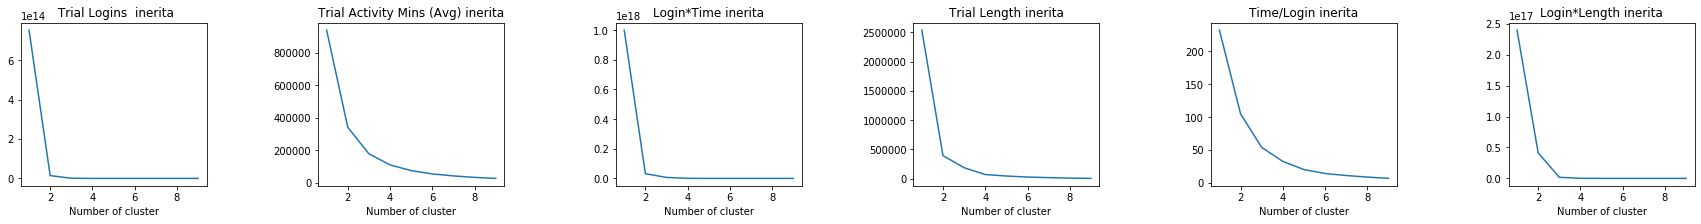

In [42]:
sub1 = other_features.iloc[:, 4:]
cols = sub1.columns 
f,axes = plt.subplots(1,6,figsize=(30, 3))

for j in range(len(cols)): 
    plt.subplot(1,6,j+1)
    kfit = [KMeans(n_clusters = k, max_iter=1000).fit(df2[[cols[j]]].fillna(0)) for k in range(1,10)]
    labels = [k.labels_ for k in kfit]
    interia = [k.inertia_ for k in kfit]
    plt.title(cols[j] + ' inerita')
    plt.plot(range(1,10), interia)
    plt.xlabel("Number of cluster")
    f.subplots_adjust(wspace=.6);
 
    


In [43]:
clusters = [2,3,2,3,3,3,3]
names = ['login_cluster','avg_min_cluster','login*time_cluster','trial_length_cluster','time/login_cluster',
         'login/time_cluster',
        'Login*Length_cluster']
for k in range(6):
    kmeans = KMeans(n_clusters = clusters[k])
    kmeans.fit(df2[[cols[k]]].fillna(0))
    df2[names[k]] = kmeans.labels_.astype(float)

In [44]:
df2.head()

index  Account ID Cancel Date Created Date Initial Trial End Date  \
0      0      108353  2020-07-21   2020-06-23             2020-07-21   
1      1      126796  2021-02-05   2020-10-08             2020-11-05   
2      2      131192  2020-11-28   2020-10-31             2020-11-28   
3      3      113953         NaT   2020-07-29             2020-08-26   
4      4       99550         NaT   2020-05-06             2020-06-03   

    Trial Logins   Trial Activity Mins (Avg)   Login*Time  Trial Length  \
0           218.0                  11.800000  2572.400000            28   
1           205.0                  13.196891  2705.362655            28   
2           193.0                  10.800000  2084.400000            28   
3           186.0                  15.060606  2801.272716            28   
4           174.0                  10.681818  1858.636332            28   

   Time/Login  ...  Uploaded Video Durring Trial  Experience_Existing Online  \
0    0.054128  ...                           0.0                           0   
1    0.064375  ...                           0.0                           0   
2    0.055959  ...                           0.0                           0   
3    0.080971  ...                           0.0                           0   
4    0.061390  ...                           0.0                           1   

   Experience_Existing Physical  Experience_New Business  login_cluster  \
0                             0                        0            0.0   
1                             0                        1            0.0   
2                             1                        0            0.0   
3                             0                        1            0.0   
4                             0                        0            0.0   

   avg_min_cluster  login*time_cluster  trial_length_cluster  \
0              0.0                 0.0                   0.0   
1              0.0                 0.0                   0.0   
2              0.0                 0.0                   0.0   
3              1.0                 0.0                   0.0   
4              0.0                 0.0                   0.0   

   time/login_cluster  login/time_cluster  
0                 0.0                 0.0  
1                 0.0                 0.0  
2                 0.0                 0.0  
3                 0.0                 0.0  
4                 0.0                 0.0  

[5 rows x 29 columns]

Now let's cluster the industries by their name. Below I vectorize the industries by it's name and then apply Kmeans.

(38893, 28)


academics  beauty  business  design  development  family  fashion  finance  \
0          0       0         0       0            0       0        0        0   
1          0       0         0       0            0       0        0        0   
2          1       0         0       0            0       0        0        0   
3          0       0         0       0            0       0        0        0   
4          0       0         0       0            0       0        0        0   

   fitness  health  ...  parenting  personal  photo  productivity  software  \
0        0       0  ...          0         0      0             0         0   
1        1       1  ...          0         0      0             0         0   
2        0       0  ...          0         0      0             0         0   
3        0       0  ...          0         0      0             0         0   
4        0       0  ...          0         0      0             0         0   

   teacher  technology  training  travel  video  
0        0           0         0       0      0  
1        0           0         0       0      0  
2        1           0         1       0      0  
3        0           0         0       0      0  
4        0           0         0       0      0  

[5 rows x 28 columns]

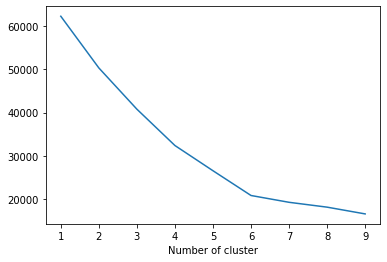

In [45]:
ind_names = df.Industry.fillna('na')

vectorizer = CountVectorizer(stop_words="english")
X = vectorizer.fit_transform(ind_names)
print(X.shape)
#print("Words:", list(enumerate(vectorizer.get_feature_names()))[0:10])


words = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
display(words.head())


kfit = [KMeans(n_clusters = k, max_iter=1000).fit(words) for k in range(1,10)]
labels = [k.labels_ for k in kfit]
interia = [k.inertia_ for k in kfit]
plt.title('')
plt.plot(range(1,10), interia)
plt.xlabel("Number of cluster");




In [46]:
kmeans = KMeans(n_clusters = 9)
kmeans.fit(words)
industry_clusters = kmeans.labels_.astype(float)


In [47]:
def standardize(data):
    '''
    Input: Dataframe 
    Output: Standardized dataframe
    '''
    ss = StandardScaler()
    col_names = data.columns
    indx = data.index
    data = pd.DataFrame(ss.fit_transform(data)) #Standardize 
    data.set_index(indx, inplace = True)
    data.columns = col_names
    
    return data


def redundant_features(df):
    '''
    Input: Dataframe
    Output: Dataframe without redundant features
    '''
    
    correlated_features = set()
    correlation_matrix = df.iloc[:,10:].corr()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > 0.8:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
    df.drop(labels=correlated_features, axis=1, inplace=True)
    
    return df

Below I set up the design matrix X and repsonse y

In [48]:
x = df2.drop(columns = ['Has Activated (Yes / No)', 'index']).iloc[:,5:].isna()
x.T[np.array(x.sum() > 0) == True].sum(axis = 1) #Check null values

Trial Activity Mins (Avg)        263
Created Offer Durring Trial     2378
Uploaded Video Durring Trial    2378
dtype: int64

In [49]:
y = df2['Has Activated (Yes / No)']
X = df2.drop(columns = ['Has Activated (Yes / No)', 'index']).iloc[:,5:].astype(float).fillna(0)
X['industry_clusters'] = industry_clusters
X['industry_clusters'] = X['industry_clusters'].astype(float)
#X = X[X.apply(lambda x: np.abs(x - x.mean()) / x.std() < 1).all(axis=1)]
X = redundant_features(standardize(X))
y = y[X.index]

Lastly, let's train and test the model using a gradient boosted decision tree.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state = 43)

model = xgb.XGBClassifier(max_depth=5, 
                              learning_rate=0.08, 
                          objective= 'binary:logistic',
                          n_jobs=-1,
                         eval_metric = 'logloss',
                         use_label_encoder=False).fit(X_train, y_train)


print('Accuracy of XGB classifier on training set: {:.3f}'
       .format(model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.3f}'
       .format(model.score(X_test[X_train.columns], y_test)))

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 0.743
Accuracy of XGB classifier on test set: 0.734
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      2036
           1       0.73      0.70      0.72      1854

    accuracy                           0.73      3890
   macro avg       0.73      0.73      0.73      3890
weighted avg       0.73      0.73      0.73      3890



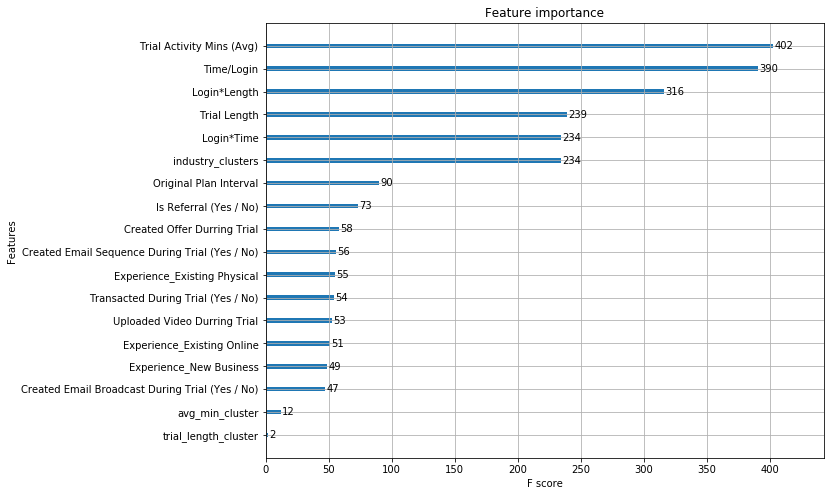

In [51]:
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(model, ax=ax);

Since I am not happy with the performance of the model, I am going to try training a neural network to see if I can get the accuracy up a bit. The following code is credited to this article: https://towardsdatascience.com/churn-prediction-using-neural-networks-and-ml-models-c817aadb7057


In [54]:
nn_model = Sequential()
nn_model.add(Dense(64,kernel_regularizer=tf.keras.regularizers.l2(0.001), input_dim=20, activation='relu' ))
nn_model.add(Dropout(rate=0.2))
nn_model.add(Dense(8,kernel_regularizer=tf.keras.regularizers.l2(0.001),activation='relu'))
nn_model.add(Dropout(rate=0.1))
nn_model.add(Dense(1, activation='sigmoid'))
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay( 0.001,
      decay_steps=(X_train.shape[0]/32)*50,
      decay_rate=1,
      staircase=False)


#This time decay means for every 50 epochs the learning rate will be half of 0.001 value
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)
def get_callbacks():
    return [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=70,restore_best_weights=True)]
nn_model.compile(loss = "binary_crossentropy", 
                  optimizer = get_optimizer(), 
                  metrics=['accuracy'])


history = nn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=32,   callbacks=get_callbacks(),verbose=0)

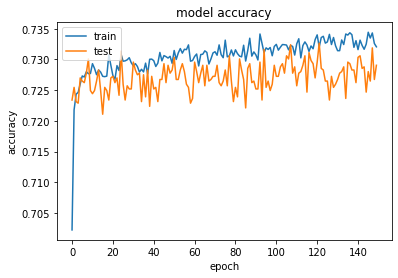

In [55]:
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

In [56]:
yprednn = nn_model.predict(X_test)
yprednn = yprednn.round()
print('Neural Network:\n {}\n'.format(
    metrics.classification_report(yprednn, y_test)))
nn_conf_matrix = metrics.confusion_matrix(yprednn,y_test)
conf_mat_nn = pd.DataFrame(nn_conf_matrix, 
    columns=["Predicted NO", "Predicted YES"], 
    index=["Actual NO", "Actual YES"])
print(conf_mat_nn)

Neural Network:
               precision    recall  f1-score   support

         0.0       0.75      0.74      0.74      2056
         1.0       0.71      0.72      0.71      1834

    accuracy                           0.73      3890
   macro avg       0.73      0.73      0.73      3890
weighted avg       0.73      0.73      0.73      3890


            Predicted NO  Predicted YES
Actual NO           1519            537
Actual YES           517           1317
